cross entropy loss　分類問題

In [2]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"/ctorch

/content/drive/My Drive/Colab Notebooks/ctorch


In [4]:
! pip install lark-parser

     |████████████████████████████████| 235kB 14.6MB/s 
  Created wheel for lark-parser: filename=lark_parser-0.11.3-py2.py3-none-any.whl size=99739 sha256=13a4aa81f62dfe20db066b6af56d6df0203d97430e1257979d1f73751586db4a
  Stored in directory: /root/.cache/pip/wheels/81/4d/b0/a94848d29b8ea206b0ef798ad241e6ebbcbc51825bec7832d3
Successfully built lark-parser


In [5]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch
import minictorch.generator as GN
import minictorch.converter as CV

ニューラルネットワークの定義

In [6]:
class Net(torch.nn.Module):
  def __init__( self, t ):
    super(Net, self).__init__()
    #self.fc1 = nn.Linear(32, 16)
    #self.fc2 = nn.Linear(16, 1)
    self.target = t
  
  def forward(self,x):
    #x = F.relu(self.fc1(x))
    #x = self.fc2(x)
    loss = nn.CrossEntropyLoss()
    output = loss(x,self.target)
    return output

In [8]:
def generate_json( json_path, input, target ):

    model = Net( target )

    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

torch.manual_seed( 1 )

input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

project = 'cse1'
json_path = 'network/' + project +'.json'

model = generate_json( json_path, input, target )

with torch.set_grad_enabled(True):
  output = model( input )
  print(output)
  output.backward()
  print("input",input.grad)

[SAVE] network/cse1.json
name: input/x
name: output/output.1
name: Net/4
name: Net/5
name: Net/6
name: Net/7
name: Net/8
tensor(1.9087, grad_fn=<NllLossBackward>)
input tensor([[ 0.0949,  0.0640, -0.2812,  0.0912,  0.0312],
        [ 0.0817,  0.0210,  0.1412, -0.2988,  0.0549],
        [ 0.0335,  0.0770, -0.2662,  0.0311,  0.1246]])


In [9]:
def convert_json( project, model, input_x, json_path, rand_flag=0 ):

    folder = "src"
    cpp_fname   = project + ".cpp"
    param_fname = project + "_param.cpp"
    cpp_path    = folder + "/" + cpp_fname
    param_path  = folder + "/" + param_fname
    make_path   = folder + "/" + "Makefile"

    # load json file
    print( "[JSON]", json_path )
    fp = open( json_path )
    obj = json.load( fp )

    # save parameter file
    code1 = CV.c_param_generator( obj, model, input_x )
    if len( code1 ) > 0:
       print( "[PARAM]", param_path )
       ofparam = open( param_path, "w" )
       ofparam.write( code1 )

    # save cpp file
    print( "[CPP]  ", cpp_path )
    code2 = CV.c_code_generator( obj, model, rand_flag )

    #ofp=open(args.path+"/"+args.output,"w")
    ofp = open( cpp_path, "w" )
    ofp.write( code2 )

    # save make file
    print( "[MAKE] ", make_path )
    make_code = CV.makefile_generator( cpp_fname )

    #makefp=open(args.path+"/"+"Makefile","w")
    makefp = open( make_path, "w" )
    makefp.write( make_code )

convert_json( project, model, input, json_path )

[JSON] network/cse1.json
[PARAM] src/cse1_param.cpp
[CPP]   src/cse1.cpp
{'name': 'input/x', 'op': 'IO Node', 'in': [], 'shape': [3, 5], 'out': [5], 'sorted_id': 0}
{'name': 'Net/4', 'op': 'prim::Constant', 'in': [], 'shape': [3], 'constant_value': [2.0, 3.0, 2.0], 'out': [5], 'sorted_id': 1}
{'name': 'Net/5', 'op': 'prim::Constant', 'in': [], 'shape': [], 'out': [5], 'sorted_id': 2}
{'name': 'Net/6', 'op': 'prim::Constant', 'in': [], 'shape': [], 'constant_value': 1.0, 'out': [5], 'sorted_id': 3}
{'name': 'Net/7', 'op': 'prim::Constant', 'in': [], 'shape': [], 'constant_value': -100.0, 'out': [5], 'sorted_id': 4}
{'name': 'Net/8', 'op': 'aten::cross_entropy_loss', 'in': [0, 1, 2, 3, 4], 'shape': [], 'out': [6], 'sorted_id': 5}
unknown op:aten::cross_entropy_loss
unique:  [0, 1, 2, 3, 4]
{'name': 'output/output.1', 'op': 'IO Node', 'in': [5], 'shape': [], 'out': [], 'sorted_id': 6}
[MAKE]  src/Makefile


In [10]:
!g++ -std=c++14 ./src/cse1.cpp ./src/cse1_param.cpp -I ./lib -lblas -o cse1

In [11]:
!./cse1

In [ ]:
!./sampl1

### forward computation ...
div(forward)
linear(forward)
relu(forward)
linear(forward)
relu(forward)
linear(forward)
{ 67.489601}
### backward computation ...
div(backward)
sum(backward)
pow{{-0.253685},
 {-0.285846},
 {-0.048311},
 {-0.080062},
 {-0.056483},
 {-0.126896},
 {-0.108684},
 {-0.072938},
 {-0.28389 },
 {-0.096729},
 {-0.094982},
 {-0.255583},
 {-0.235605},
 {-0.064879},
 {-0.065968},
 {-0.183502},
 {-0.126423},
 {-0.090989},
 {-0.107264},
 {-0.064815},
 {-0.268737},
 {-0.112874},
 {-0.087223},
 {-0.248318},
 {-0.064156},
 {-0.193692},
 {-0.054966},
 {-0.050817},
 {-0.103733},
 {-0.050786},
 {-0.104911},
 {-0.249499},
 {-0.04678 },
 {-0.030518},
 {-0.251702},
 {-0.176465},
 {-0.120189},
 {-0.188519},
 {-0.105802},
 {-0.251025},
 {-0.058483},
 {-0.275494},
 {-0.236303},
 {-0.282973},
 {-0.094245},
 {-0.098045},
 {-0.148212},
 {-0.07843 },
 {-0.118661},
 {-0.050341},
 {-0.061316},
 {-0.076551},
 {-0.103575},
 {-0.118201},
 {-0.089486},
 {-0.06564 },
 {-0.078567},
 {-0.278211}

学習

In [ ]:
num_epochs = 1000

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y.reshape(-1, 1)).float()

net = Net()
net.train()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

epoch_loss = []
for epoch in range(num_epochs):
  
  outputs = net(x_tensor)
  loss = criterion(outputs, y_tensor)
    
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
    
  epoch_loss.append(loss.data.numpy().tolist())


Net(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)
True
True
True
True
True
True
<generator object Module.named_parameters at 0x7f99790439d0>
fc1.weight
True
None
---
fc1.bias
True
None
---
fc2.weight
True
None
---
fc2.bias
True
None
---
fc3.weight
True
None
---
fc3.bias
True
None
---
Parameter containing:
tensor([[ 0.3874, -0.5647],
        [-0.6766,  0.6111],
        [ 0.4934, -0.6330],
        [ 0.5197,  0.3673],
        [-0.2603, -0.0761],
        [-0.3394,  0.0356],
        [ 0.4697, -0.0500],
        [-0.3039,  0.2805],
        [ 0.1860, -0.6480],
        [ 0.3688, -0.1265],
        [ 0.2277, -0.5620],
        [ 0.6186, -0.1891],
        [ 0.4563, -0.3899],
        [-0.0606,  0.5275],
        [-0.2258, -0.6937],
        [-0.6117,  0.6076],
        [-0.1122,  0.6290],
        [-0.3709,  0.4826],
        [ 0.2488, -0.6291],
        [ 0.3292,  0.6114]

'\nepoch_loss = []\nfor epoch in range(num_epochs):\n  \n  outputs = net(x_tensor)\n  loss = criterion(outputs, y_tensor)\n    \n  optimizer.zero_grad()\n  loss.backward()\n  optimizer.step()\n    \n  epoch_loss.append(loss.data.numpy().tolist())\n'

学習の収束の図化

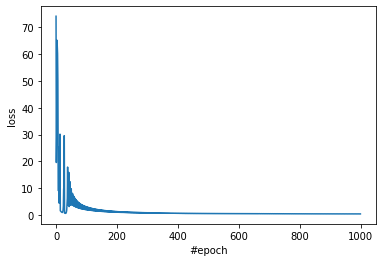

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

予測

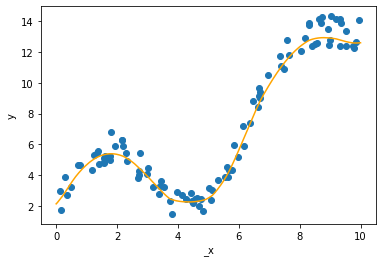

In [ ]:
net.eval()

_x_new = np.linspace(0, 10, 1000)
x1_new = np.sin(_x_new)
x2_new = np.exp(_x_new / 5)
x_new = np.stack([x1_new, x2_new], axis=1)


x_new_tensor = torch.from_numpy(x_new).float()
with torch.no_grad():
    y_pred_tensor = net(x_new_tensor)

y_pred = y_pred_tensor.data.numpy()



fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(_x, y)
ax.plot(_x_new, y_pred, c='orange')
ax.set_xlabel('_x')
ax.set_ylabel('y')
fig.show()

[ ミニバッチ学習 ]

サンプルデータ

In [ ]:
import numpy as np

np.random.seed(2020)
_x = np.random.uniform(0, 10, 100)
x1 = np.sin(_x)
x2 = np.exp(_x / 5)
x = np.stack([x1, x2], axis=1)
y = 3 * x1 + 2 * x2 + np.random.uniform(-1, 1, 100)

DataSetクラスの定義

In [ ]:
import torch

class MakeDataset(torch.utils.data.Dataset):

    def __init__(self, x, y=None):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        x = torch.from_numpy(self.x[i]).float()
        if self.y is not None:
            y = torch.from_numpy(self.y[i]).float()
        
        if self.y is not None:
            return x, y
        else:
            return x

ニューラルネットワークの定義

In [ ]:
import torch
import torch.nn.functional
import torch.utils.data


class Net(torch.nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = torch.nn.Linear(2, 64)
    self.fc2 = torch.nn.Linear(64, 32)
    self.fc3 = torch.nn.Linear(32, 1)

  def forward(self, x):
    x = torch.nn.functional.relu(self.fc1(x))
    x = torch.nn.functional.relu(self.fc2(x))
    x = self.fc3(x)
    return x

ミニバッチ学習

In [ ]:
num_epochs = 1000
batch_size = 64

# prepare dataset
dataset = MakeDataset(x, y.reshape(-1, 1))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# prepare model and training parameters
net = Net()
net.train()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# training
epoch_loss = []
for epoch in range(num_epochs):
    
    # use 'dataloader' to start batch learning
    running_loss = 0   # loss in this epoch
    for inputs, labels in dataloader:
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # add loss of this batch to loss of epoch
        running_loss += loss.data.numpy().tolist()
    
    epoch_loss.append(running_loss)

予測

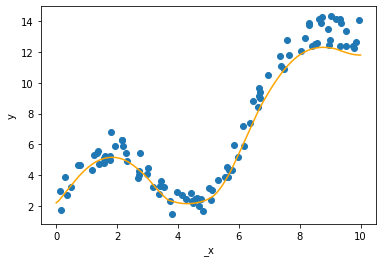

In [ ]:
net.eval()

_x_new = np.linspace(0, 10, 1000)
x1_new = np.sin(_x_new)
x2_new = np.exp(_x_new / 5)
x_new = np.stack([x1_new, x2_new], axis=1)


test_dataset = MakeDataset(x_new)
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

y_pred = None
with torch.no_grad():
    for inputs in dataloader:
        outputs = net(inputs)
        if y_pred is None:
            y_pred = outputs.data.numpy()
        else:
            y_pred = np.concatenate([y_pred, outputs.data.numpy()])

y_pred = y_pred.reshape(-1)

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(_x, y)
ax.plot(_x_new, y_pred, c='orange')
ax.set_xlabel('_x')
ax.set_ylabel('y')
fig.show()

In [ ]:
x_tensor

tensor([[-0.4241,  7.1890],
        [ 0.6372,  5.7361],
        [-0.9268,  2.7718],
        [ 0.4107,  1.7223],
        [-0.2256,  1.9618],
        [ 0.8260,  1.5433],
        [ 0.3680,  1.7384],
        [-0.2874,  1.9870],
        [ 0.7196,  5.6087],
        [ 1.0000,  1.3681],
        [ 0.9869,  1.3255],
        [ 0.9602,  4.5456],
        [ 0.8820,  4.3608],
        [-0.4032,  2.0367],
        [-0.2661,  1.9782],
        [ 0.3754,  3.7947],
        [ 0.8252,  1.5437],
        [-0.6201,  3.0736],
        [ 0.9464,  1.2819],
        [-0.0557,  1.8955],
        [-0.1072,  6.7290],
        [ 0.9806,  1.3162],
        [-0.5556,  3.1231],
        [-0.3258,  7.0380],
        [-0.9488,  2.7366],
        [ 0.3834,  3.8012],
        [ 0.3353,  1.0708],
        [-0.9886,  2.4899],
        [ 0.9999,  1.3657],
        [-0.9988,  2.5911],
        [ 0.9920,  1.4041],
        [ 0.4459,  6.0045],
        [-0.5583,  2.1102],
        [-0.6094,  2.1370],
        [ 0.7457,  5.5658],
        [ 0.1765,  3

In [ ]:
x = torch.arange(3).view(1, 3)
y = torch.arange(2).view(2, 1)
a, b = torch.broadcast_tensors(x, y)
print(x.size(),y.size())
print(a.size(),b.size())

torch.Size([1, 3]) torch.Size([2, 1])
torch.Size([2, 3]) torch.Size([2, 3])


In [ ]:
print(x)

tensor([[0, 1, 2]])


In [ ]:
print(a)

tensor([[0, 1, 2],
        [0, 1, 2]])


In [ ]:
print(y)

tensor([[0],
        [1]])


In [ ]:
print(b)

tensor([[0, 0, 0],
        [1, 1, 1]])


In [ ]:
print(x.shape)

torch.Size([1, 3])


In [ ]:
x2=torch.empty(x.shape)
y2=torch.empty(y.shape)
s2=(x2+y2).size()

In [ ]:
a2=x.expand(s2)
b2=y.expand(s2)
print(a2)
print(b2)

tensor([[0, 1, 2],
        [0, 1, 2]])
tensor([[0, 0, 0],
        [1, 1, 1]])
